# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name : Vishruty Mittal
### ID : 5584825

## Student 2
### Name : Sayak Mukherjee
### ID : 5222273

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [78]:
import pandas as pd
import numpy as np
import mmh3
import os, json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from nltk import ngrams
from collections import defaultdict
from functools import reduce
from itertools import permutations
from tqdm import tqdm
from flexfringe import FlexFringe

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Uncomment for colab

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# !mkdir data

# !cp '/content/drive/MyDrive/Colab Notebooks/CDA/dataset_lab3.zip' 'data/' # Location of data zipped file
# %cd data/
# !unzip dataset_lab3.zip
# %cd ..

In [5]:
data = pd.read_csv("data/dataset_10/capture20110818.binetflow")

In [6]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [7]:
def encode_data(dataframe, label_only=False, background_label = "2"):
    
    # normal traffic
    dataframe.loc[
        (dataframe["Label"].str.startswith("flow=From-Normal"))
        | (dataframe["Label"].str.startswith("flow=To-Normal"))
        | (dataframe["Label"].str.startswith("flow=Normal")),
        "Label",
    ] = "0"

    # background traffic
    dataframe.loc[
        (dataframe["Label"].str.startswith("flow=Background"))
        | (dataframe["Label"].str.startswith("flow=To-Background"))
        | (dataframe["Label"].str.startswith("flow=From-Background")),
        "Label",
    ] = background_label

    # botnet traffic
    dataframe.loc[dataframe["Label"].str.startswith("flow=From-Botnet"), "Label"] = "1"
    
    if not label_only:
        enc = LabelEncoder()
        enc.fit(dataframe["Label"])
        dataframe.loc[:, "Label"] = enc.transform(dataframe["Label"])

        enc = LabelEncoder()
        enc.fit(dataframe["Proto"])
        dataframe.loc[:, "Proto"] = enc.transform(dataframe["Proto"])

        enc = LabelEncoder()
        enc.fit(dataframe["Dir"])
        dataframe.loc[:, "Dir"] = enc.transform(dataframe["Dir"])

        enc = LabelEncoder()
        enc.fit(dataframe["Sport"])
        dataframe.loc[:, "Sport"] = enc.transform(dataframe["Sport"])

        enc = LabelEncoder()
        enc.fit(dataframe["Dport"])
        dataframe.loc[:, "Dport"] = enc.transform(dataframe["Dport"])

        enc = LabelEncoder()
        enc.fit(dataframe["sTos"])
        dataframe.loc[:, "sTos"] = enc.transform(dataframe["sTos"])

        enc = LabelEncoder()
        enc.fit(dataframe["dTos"])
        dataframe.loc[:, "dTos"] = enc.transform(dataframe["dTos"])

    return dataframe

In [8]:
# get hosts traffic without background 

hosts_wo_background = data.loc[~data.Label.str.contains('(Background)', regex=True, na=False), :]
hosts_wo_background = encode_data(hosts_wo_background)

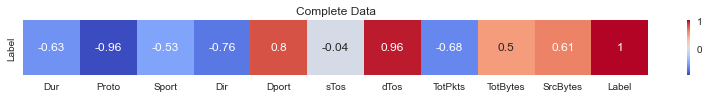

In [9]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(14, 1))
sns.heatmap(hosts_wo_background.corr("spearman").loc[['Label']],cmap = 'coolwarm', annot=True)
ax1.set_title('Complete Data')
plt.show()

In [10]:
# Find infected host by string matching Botnet in Labels

infected_hosts = data.loc[data['Label'].str.contains('Botnet', regex=True), :]
infected_hosts.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
90622,2011/08/18 10:37:58.448307,0.000342,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V51-1-UDP-DNS
90808,2011/08/18 10:38:00.695278,0.010278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V51-1-UDP-DNS
90809,2011/08/18 10:38:00.706560,0.043726,tcp,147.32.84.165,1027,->,74.125.232.206,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...
90965,2011/08/18 10:38:03.255934,0.010256,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,flow=From-Botnet-V51-1-UDP-DNS
90968,2011/08/18 10:38:03.267222,581.516663,udp,147.32.84.165,123,->,65.55.56.40,123,INT,0.0,NaN,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [11]:
# filtering for botnet with IP 147.32.84.165

infected_hosts = infected_hosts[(infected_hosts.SrcAddr == '147.32.84.165') | (infected_hosts.DstAddr == '147.32.84.165')]

In [12]:
# filtering non-malicious data without the background data 

benign_hosts = data.loc[~data.Label.str.contains('(Botnet|Background)', regex=True, na=False), :]

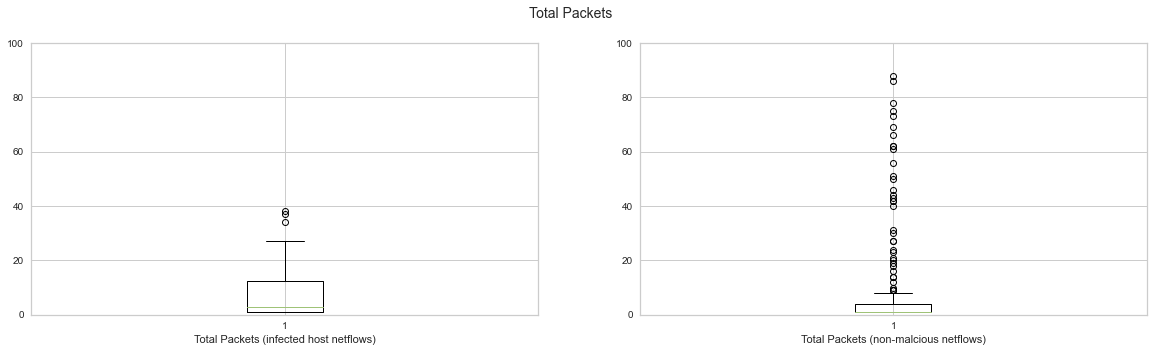

In [13]:
fig, ax = plt.subplots(1, 2, figsize =(20, 5))


# boxplot of the infected host packet values

ax[0].boxplot(infected_hosts['TotPkts'].value_counts())
ax[0].set_xlabel("Total Packets (infected host netflows)")
ax[0].set_ylim(0, 100)

# boxplot of the normal traffic (non-malicious) packet values

ax[1].boxplot(benign_hosts['TotPkts'].value_counts())
ax[1].set_xlabel("Total Packets (non-malcious netflows)")
ax[1].set_ylim(0, 100)

fig.suptitle('Total Packets', fontsize=14)

plt.show()

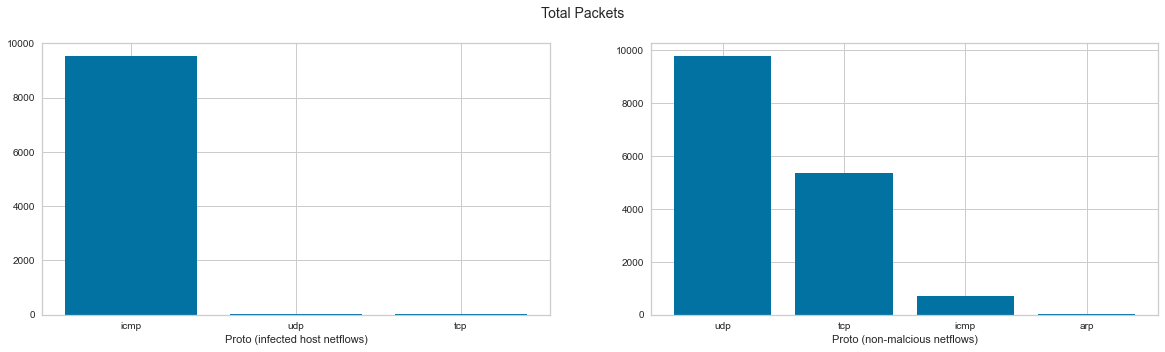

In [14]:
fig, ax = plt.subplots(1, 2, figsize =(20, 5))

proto_counts_infected = infected_hosts['Proto'].value_counts()
ax[0].bar(proto_counts_infected.index, proto_counts_infected)
ax[0].set_xlabel("Proto (infected host netflows)")

proto_counts_bening = benign_hosts['Proto'].value_counts()
ax[1].bar(proto_counts_bening.index, proto_counts_bening)
ax[1].set_xlabel("Proto (non-malcious netflows)")

fig.suptitle('Total Packets', fontsize=14)

plt.show()


### 1b. Discretize selected features

In [15]:
# removing the background data

training_data = data.loc[~data.Label.str.contains('Background', regex=True, na=False), :]

In [16]:
label_encoder = LabelEncoder()
training_data['Proto'] = label_encoder.fit_transform(training_data['Proto']) 

In [17]:
def visualize_elbow(columns):

    model = KMeans()
    elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,10))

    # Fit the data to the visualizer
    elbow_visualizer.fit(training_data[columns])     

    # Finalize and render the figure
    elbow_visualizer.show()


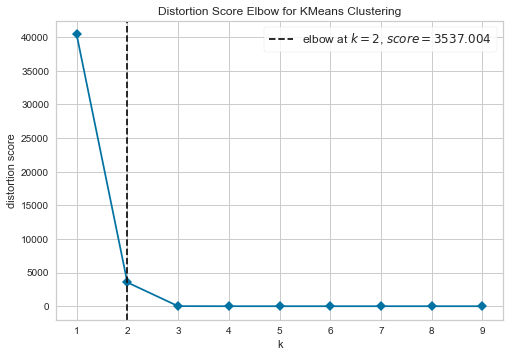

In [18]:
visualize_elbow(['Proto'])

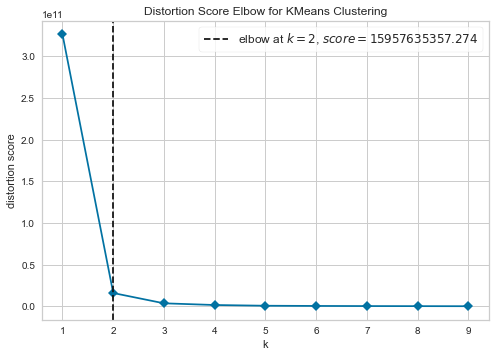

In [19]:
visualize_elbow(['TotPkts'])

In [20]:
# Global variable

MAX = {} # 0.0
MIN = {} # 0.0
BINS = {} # None
ALPHABETS = {} # None

In [21]:
# ref: https://johannfaouzi.github.io/pyts/_modules/pyts/quantization/quantization.html#SAX

def discretise(feature, feat_name, is_train=True, quantiles='linspace', levels=3):
    '''
    Discretise signal within levels
    '''
    
    global MIN, MAX, BINS, ALPHABETS
    
    is_failed = False

    # normalise
    if is_train:
        MIN[feat_name], MAX[feat_name] = 0.0, 0.0
        MIN[feat_name] = feature.min()
        MAX[feat_name] = feature.max()

    feature = (feature - MIN[feat_name]) / (MAX[feat_name] - MIN[feat_name])
    
    if MAX[feat_name] == MIN[feat_name]:
        is_failed = True
        
        # constant value signal
        return None, None, None, is_failed
    
    if is_train:
        
        # initialise the global variables
        ALPHABETS[feat_name] = None
        
        ALPHABETS[feat_name] = np.array([str(i) for i in range(levels)])
        
        # insert additional character at starting and end to encode unseen values
        ALPHABETS[feat_name] = np.insert(ALPHABETS[feat_name], 0, 'X')              
        ALPHABETS[feat_name] = np.insert(ALPHABETS[feat_name], len(ALPHABETS[feat_name]), 'X')
        
        BINS[feat_name] = None
        
        if quantiles == 'linspace':
            BINS[feat_name] = np.linspace(0., 1., levels + 1)
        else:
            BINS[feat_name] = np.percentile(feature, np.linspace(0, 100, levels + 1))
            
        BINS[feat_name][-1] += 1e-5 

    indices = np.array([np.digitize(feature, BINS[feat_name])])
    
    coded_feature = ALPHABETS[feat_name][indices] # coded signal
    
    # handling for unseen values during test
    value_beyond_lim = np.where(indices == len(BINS[feat_name]))[0]
    
    if is_train:
        if len(value_beyond_lim) > 0:
            print(f'Incorrect Values')
    else:
        
        # since it will only be used for plotting here onwards
        # map back any point that falls outside the bins to the 
        # last bin
        
        indices[value_beyond_lim] = len(BINS[feat_name]) - 1
    
    try:
        discrete_feature = BINS[feat_name][indices] # discretised signal
    except:
        print(indices)

    return  feature, coded_feature[0], discrete_feature[0], is_failed

In [22]:
FEATURE_BINS = {'Proto': 3, 'TotPkts': 2}
QUANTILES = 'linspace'

In [23]:
def discretise_cols(dataframe):
    
    for feat_name in FEATURE_BINS.keys():
        
        feature = dataframe[feat_name].values
        
        _, coded_signal, _, _ = discretise(feature, feat_name, quantiles=QUANTILES,  levels=FEATURE_BINS[feat_name])
        
        dataframe[feat_name] = coded_signal
    
    return dataframe

In [24]:
training_data = discretise_cols(training_data)

In [25]:
# Algorithm 1 from Pellegrino et.al. Learning Behavioral Fingerprints From Netflows Using Timed Automata

def attribute_mapping(dataframe):
    code = 0
    features = FEATURE_BINS.keys()
    space_size = reduce((lambda x, y: FEATURE_BINS[x] * FEATURE_BINS[y]), features)
    for feature in features:
        dataframe[feature] = dataframe[feature].astype(int)
        code = code + dataframe[feature].values * (space_size/FEATURE_BINS[feature])
        space_size = space_size/FEATURE_BINS[feature]
    return code

In [26]:
# Combining the columns

# training_data['combined_discretized'] = (training_data['Proto'].astype(int).astype(str) + training_data['TotPkts'].astype(int).astype(str))

training_data['combined_discretized'] = attribute_mapping(training_data)
training_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,combined_discretized
532,2011/08/18 10:19:15.693956,3587.569824,2,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,0,978731,245317,flow=From-Normal-V51-Grill,4.0
822,2011/08/18 10:19:18.143576,198.072739,2,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,0,924,462,flow=From-Normal-V51-Grill,4.0
842,2011/08/18 10:19:18.303590,197.928329,2,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,0,924,462,flow=From-Normal-V51-Grill,4.0
1021,2011/08/18 10:19:19.838272,0.000399,2,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,0,400,74,flow=From-Normal-V51-Stribrek,4.0
1022,2011/08/18 10:19:19.839123,0.000400,2,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,0,400,74,flow=From-Normal-V51-Stribrek,4.0


In [27]:
training_data['combined_discretized'].unique()

array([4., 0., 2., 5.])

### 1c. Answers and explanation

From the correlation plot it can be seen that the features 'Proto' and 'TotPkts' has a relatively strong negative correlation with the target label. On further investigation with the help of visualizations we observe the following:
<ol>
    <li>Boxplot for the feature 'TotPkts' shows that the infected host send more packets as compared to a benign host.</li>
    <li>The barplot for the feature 'Proto' shows that the infected host mostly use ICMP protocol whereas bening hosts mostly use UDP and TDP protocols</li>
</ol>
Hence these features can give some intuition about the current state of a host. Following this, we looked into the optimal number of bins for the selected features using the elbow method. As can be seen above, the number of bins is selected as 2 for the discretisation task following the observation.

## 2. Sketching task – 1/2 A4 (Individual, 10 Points) - Sayak Mukherjee

### 2a. COUNT-MIN sketch


In [28]:
# Create 3-grams from the discretized features

n_grams = list(ngrams(training_data.combined_discretized.values, n=3))

In [29]:
n_grams[:5]

[(4.0, 4.0, 4.0),
 (4.0, 4.0, 4.0),
 (4.0, 4.0, 4.0),
 (4.0, 4.0, 4.0),
 (4.0, 4.0, 4.0)]

In [30]:
# Get the frequencies of the 3-grams

ngram_counts = np.array(n_grams).astype(int)
ngram_counts = np.apply_along_axis((lambda x : "{:d}{:d}{:d}".format(*x)), axis=1, arr=ngram_counts)
ngram_counts = np.unique(ngram_counts, return_counts=True)

In [31]:
orig_freq = dict(zip(ngram_counts[0], ngram_counts[1]))
orig_freq

{'022': 2,
 '044': 9,
 '202': 2,
 '204': 1,
 '220': 1,
 '222': 105749,
 '224': 383,
 '242': 262,
 '244': 292,
 '404': 8,
 '420': 2,
 '422': 382,
 '424': 171,
 '440': 8,
 '442': 293,
 '444': 14620,
 '445': 1,
 '455': 1,
 '544': 1,
 '554': 1,
 '555': 8}

In [32]:
# Ref: https://github.com/pnxenopoulos/countminsketch/blob/master/countminsketch.py

SEEDS = np.random.randint(5, size=20)

class CountMin():
    
    def __init__(self, width, depth):
        
        self.width = width
        self.depth = depth
        self.cmt = np.zeros([depth, width])
        self.seeds = SEEDS
        
    def add_item(self, item):
        '''
        Add item to the countmin table
        '''
        
        # convert n-gram tuple to string
        key = ""
        for val in item:
            key += str(int(val))
        
        # add to count-min-table
        for i in range(self.depth):
            index = mmh3.hash(key, self.seeds[i]) % self.width
            self.cmt[i, index] += 1
            
    def estimate_freq(self, item):
        '''
        Gets frequency of an item in countmin table
        '''
        
        # convert n-gram tuple to string
        key = ""
        for val in item:
            key += str(int(val))
        
        frequencies = []
        
        # add to count-min-table
        for i in range(self.depth):
            index = mmh3.hash(key, self.seeds[i]) % self.width
            frequencies.append(self.cmt[i, index])
            
        return np.min(frequencies)

In [33]:
def calc_error(estimated_freq):
    '''
    Calculate the absolute error between 
    the estimated and actual frequencies
    '''
    error = 0.0
    
    for key in orig_freq.keys():
        error += abs(estimated_freq[key] - orig_freq[key])
    
    return error

def test_cm(width, depth):
    '''
    Test count min with different
    combinations of width and depth
    '''
    cm = CountMin(width, depth)
    
    for n_gram in n_grams:
        cm.add_item(n_gram)
        
    cm_freq = {}

    for n_gram in ngram_counts[0]:
        cm_freq[n_gram] = cm.estimate_freq(n_gram)
    
    return cm_freq

In [34]:
# Calculate error with different combinations

widths = [5, 10, 20, 40, 80]
depths = [2, 4, 6, 8, 10]

results = np.zeros([len(depths), len(widths)])

with tqdm(total=len(depths)*len(widths)) as pbar:
    for i, w in enumerate(widths):
        for j, d in enumerate(depths):
            estimated = test_cm(w, d)
            results[i-1, j-1] = calc_error(estimated)
            pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.40s/it]


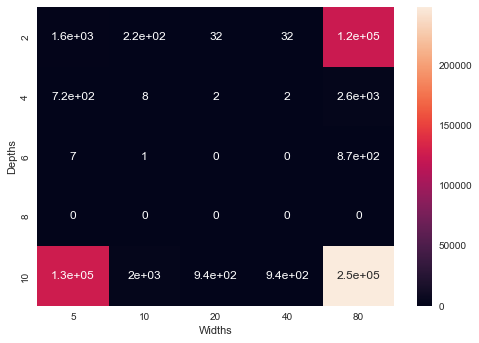

In [35]:
# Plot the results

sns.heatmap(results, annot=True, xticklabels=widths, yticklabels=depths)
plt.xlabel('Widths')
plt.ylabel('Depths')
plt.show()

### 2b. Analysis and answers to the questions

COUNT-MIN sketching is more efficient in terms of space and computational complexity. For calculating the frequency of `3-grams`, we need to store the frequencies in a datastructure that is atleast as big as the number of unique `3-grams`. It is not the case with COUNT-MIX where we can store all the frequencies in even smaller space. Secondly, for incrementing the count corresponding to an `3-gram`, first we need to locate the `3-gram` in the datastructure which requires searching. Binary search in such a scenario will have `O(logN)` complexity. Whereas, streaming data can be stored with `O(1)` complexity using a COUNT-MIX sketch.

However, COUNT-MIX is not accurate for all combinations of height and width as seen in the heatmap above. There might be estimation errors. Hence it is ideal when there is a limitation in space and computational resource. Also, it can be used when only the relative comparison is important rather than a precise estimate.

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

In [36]:
# Process the data
processed_data = data.copy()
processed_data = encode_data(processed_data, label_only=False, background_label = "0") 
processed_data = discretise_cols(processed_data)
processed_data['combined_discretized'] = attribute_mapping(processed_data)

# Store the sybmols
DATA_SYMBOLS = processed_data.combined_discretized.unique()

processed_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,combined_discretized
0,2011/08/18 10:21:46.633335,1.060248,2,93.45.239.29,58246,0,147.32.84.118,45130,S_RA,0,0,0,252,132,0,4.0
1,2011/08/18 10:19:49.027650,279.349152,2,62.240.166.118,52051,4,147.32.84.229,8645,SRPA_PA,0,0,0,1318,955,0,4.0
2,2011/08/18 10:22:07.160628,166.390015,2,147.32.86.148,103466,0,66.235.132.232,45863,SR_SA,0,0,0,212,134,0,4.0
3,2011/08/18 10:26:02.052163,1.187083,2,147.32.3.51,74132,0,147.32.84.46,6293,S_RA,0,0,0,244,124,0,4.0
4,2011/08/18 10:26:52.226748,0.980571,2,88.212.37.169,74173,0,147.32.84.118,45130,S_RA,0,0,0,244,124,0,4.0


In [37]:
# Get list of infected and benign IPs

ips_with_labels = processed_data[['SrcAddr', 'Label']].groupby(by='SrcAddr').max()
ips_with_labels = ips_with_labels.reset_index()

infected_ips = ips_with_labels[ips_with_labels.Label == 1].SrcAddr.tolist()
benign_ips = ips_with_labels[ips_with_labels.Label == 0].SrcAddr.tolist()

In [38]:
# Note: The code has been tested on a windows system 
# with the corresponding binary. The executable is stored
# in the `binaries` directory

FLEXFRINGE = None

def gen_signature(host_data, host_ip, is_train=True):
    
    global FLEXFRINGE
    
    signature = {} # store signature of the host
    signature[host_ip] = {}
    
    # temp directory for flex-fringe processing
    if not os.path.isdir('data/ff'):
        os.mkdir('data/ff')
    
    # execute flex-fringe
    sources = host_data.SrcAddr.values
    labels = host_data.Label.values
    discretized_feat = host_data.combined_discretized.values
    
    flex_trainset = {'id':sources,'type': labels, 'symbol': discretized_feat}
    flex_trainset = pd.DataFrame(flex_trainset)
    flex_trainset.to_csv('data/ff/flex_trace.csv', index=None)
    
    if is_train:
        
        FLEXFRINGE = FlexFringe(
            flexfringe_path="binaries/flexfringe-x64-windows",
            heuristic_name="alergia",
            data_name="alergia_data",
            slidingwindow=1,
            swsize=10,
        )
        
        # Learn a state machine
        FLEXFRINGE.fit('data/ff/flex_trace.csv')
    
    else:

        # Use state machine to predict likelihoods
        df = FLEXFRINGE.predict('data/ff/flex_trace.csv')
    
    # process results
    results = None
    
    with open('data/ff/flex_trace.csv.ff.final.json') as f:
        results = json.load(f)
    
    for node in results['nodes']:
        
        for symbol in DATA_SYMBOLS:
            signature[host_ip][str(symbol)] = 0.0
            
        for symbol in node['data']['trans_counts'].keys():
            signature[host_ip][symbol] += int(node['data']['trans_counts'][symbol])
            
    return pd.DataFrame(signature).T

In [39]:
infected_host_sample = processed_data[processed_data.SrcAddr == infected_ips[0]]

train_signature = gen_signature(infected_host_sample, infected_ips[0], is_train=True)

train_signature

Running:  flexfringe data/ff/flex_trace.csv --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10
0 Using heuristic alergia
Creating apta using evaluation class alergia
batch mode selected
 m1.39597  m0 no more possible merges
 starting greedy merging
deleted merger



,0.0,2.0,4.0,5.0
147.32.84.165,19074.0,0.0,81.0,0.0


In [99]:
# Note: For faster execution, number of benign samples restricted to 1000
# Uncomment to run or follow along with precomputed values

# # collect signatures for the remaining hosts
# test_signatures = None
# test_labels = []

# # collect signatures for the infected hosts
# for i, ip in enumerate(infected_ips[1:]):
#     host_data = processed_data[processed_data.SrcAddr == ip]
#     if i == 0:
#         test_signatures = gen_signature(host_data, ip)
#     else:
#         test_signatures = pd.concat([test_signatures, gen_signature(host_data, ip)])
#     test_labels.append(1)

# # collect signatures for the benign hosts
# for i, ip in enumerate(benign_ips[:1000]):
#     host_data = processed_data[processed_data.SrcAddr == ip]
#     test_signatures = pd.concat([test_signatures, gen_signature(host_data, ip)])
#     test_labels.append(0)

# # Save to file for ease of use

# test_df = pd.concat([test_signatures.rename_axis('SrcAddr').reset_index(), 
#                      pd.DataFrame(test_labels, columns=['label'])], axis=1)
# test_df.to_csv('data/test_signatures.csv', index=None)

In [105]:
test_df = pd.read_csv('data/test_signatures.csv')
test_df.head()

,SrcAddr,0.0,2.0,4.0,5.0,label
0,147.32.84.191,20830.0,0.0,75.0,0.0,1
1,147.32.84.192,20725.0,0.0,63.0,0.0,1
2,147.32.84.193,19940.0,0.0,75.0,0.0,1
3,147.32.84.204,22250.0,0.0,65.0,0.0,1
4,147.32.84.205,23672.0,0.0,73.0,0.0,1


In [106]:
test_labels = test_df.label.values.tolist()

In [110]:
test_signatures = test_df[['0.0', '2.0', '4.0', '5.0']]
test_signatures.index = test_df.SrcAddr.values
test_signatures.head()

,0.0,2.0,4.0,5.0
147.32.84.191,20830.0,0.0,75.0,0.0
147.32.84.192,20725.0,0.0,63.0,0.0
147.32.84.193,19940.0,0.0,75.0,0.0
147.32.84.204,22250.0,0.0,65.0,0.0
147.32.84.205,23672.0,0.0,73.0,0.0


In [111]:
def calc_distance(train_signatures, test_signatures):
    '''
    calculates distances of signatures
    '''
    
    neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
    neigh.fit(train_signatures.values)
    
    # find distances to the nearest neigbour
    distances, _ = neigh.kneighbors(test_signatures.values, return_distance = True)
    
    return distances

In [112]:
# calculate distances
distances = calc_distance(train_signature, test_signatures)

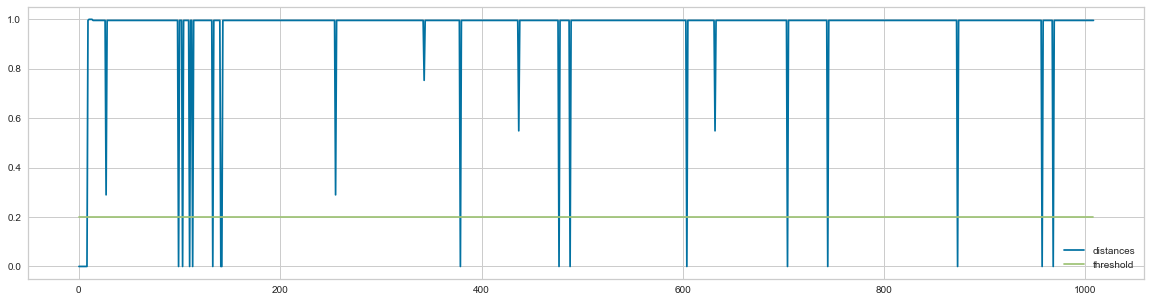

In [113]:
# distance of each data point from its nearest neighbor
fig, ax = plt.subplots(1,figsize=(20,5))

ax.plot(distances, label='distances')
ax.plot(range(len(distances)), np.array([0.2] * len(distances)), label='threshold')
ax.legend()
plt.show()

In [114]:
# get predictions using the threshold decided from the plot above

predictions = np.array(distances.reshape(-1) < 0.2).astype(int) # Threshold set to 0.2

In [115]:
# To-Do: Plot the counts of a true/false positive and true/false negative in a scatter plot 

confusion_matrix(np.array(test_labels), predictions)

array([[984,  16],
       [  0,   9]], dtype=int64)

In [116]:
# Looking for fingerprints

test_df[:20] # State 0.0 occurs frequently for the botnet

,SrcAddr,0.0,2.0,4.0,5.0,label
0,147.32.84.191,20830.0,0.0,75.0,0.0,1
1,147.32.84.192,20725.0,0.0,63.0,0.0,1
2,147.32.84.193,19940.0,0.0,75.0,0.0,1
3,147.32.84.204,22250.0,0.0,65.0,0.0,1
4,147.32.84.205,23672.0,0.0,73.0,0.0,1
5,147.32.84.206,22504.0,0.0,64.0,0.0,1
6,147.32.84.207,21082.0,0.0,74.0,0.0,1
7,147.32.84.208,22162.0,0.0,67.0,0.0,1
8,147.32.84.209,19714.0,0.0,75.0,0.0,1
9,0.0.0.0,0.0,0.0,5.0,0.0,0


In [117]:
# get indexes where a host was predicted as a botnet

np.where(predictions == 1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  99, 103, 110, 113,
        133, 141, 142, 379, 477, 488, 604, 704, 744, 873, 957, 968],
       dtype=int64),)

In [118]:
# These got marked as botnets as they have the occurence of state 0.0

test_df.iloc[[99, 103, 110, 113]] 

,SrcAddr,0.0,2.0,4.0,5.0,label
99,1.168.137.213,1.0,0.0,0.0,0.0,0
103,1.169.139.125,1.0,0.0,0.0,0.0,0
110,1.169.189.21,1.0,0.0,0.0,0.0,0
113,1.169.190.98,1.0,0.0,0.0,0.0,0


### 4b. Analysis and answers to the questions.

After selecting a infected host, we calculate the distances of the other host signatures from the infected host signatures. Analyzing the distances plot, it can be seen that `0.2` can be used as a threshold. <br>
We look at the signatures of 9 infected hosts and 11 benign hosts. It can be inferred that the state `0.0` occurs frequently in the infected hosts and thus can be considered as a fingerprint of the botnet. <br>
Finally, looking at a few benign host signatures that got marked as botnet, we notice that falsely marked hosts also contain the state `0.0` which as mentioned earlier is the fingerprint of the botnet.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.